### ZNE with partial folding to obtain competitive expectation values for deep circuits

Zero Noise Extrapolation (ZNE) is an error mitigation technique used to obtain expectation values closer to the ideal noiseless value from a noisy quantum computer. ZNE can be classified broadly into three types - (i) analog ZNE, (ii) digital ZNE, and (iv) PEA ZNE. In this notebook we select digital ZNE primarily because it has a much simpler implementation than analog ZNE (Physical review letters, 119(18), 180509), and does not require the time consuming $learning$ step of PEA ZNE (Nature, 618(7965), 500-505).

The general idea of digital ZNE (dZNE) is to replace some gates $U$ by $U(U^{\dagger}U)^{\lambda}$ for some $\lambda \geq 1$. This ensures that the functionality of the circuit remains unchanged (since $U^{\dagger}U = I$ $\forall$ $U$), however, the noise is increased due to the increased number of gates. The expectation values are obtained for different values of $\lambda$, and then extrapolated to $\lambda = 0$ to obtain an estimate of the expectation value in zero noise limit.

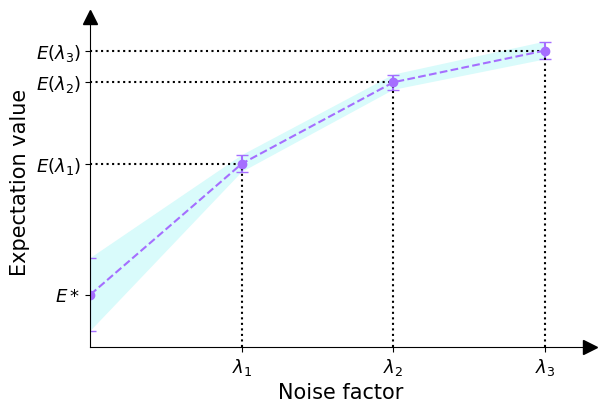

### Start

We shall consider a $p=3$ QAOA circuit as an example for this notebook.

### Build

We consider a compute-uncompute circuit for this notebook. For any circuit, represented by the circuit unitary $U$, a compute-uncompute circuit appends $U^{-1}$ to it. This ensures that, in the noiseless scenario, the outcome is $|0\rangle^{\otimes n}$ where $n$ is the number of qubits. Therefore, the ideal expectation value of any $Z$ type observable is +1. This method ensures that the ideal outcome is known without explicit simulation.

Note that in Qiskit the $U$ and $U^{-1}$ must be separated by a barrier so that the transpiler does not optimize the circuit to identity during execution.

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from numpy.random import default_rng
from numpy import pi

def build_compute_uncompute_qaoa_circuit(
    num_qubits: int,
    depth: int, # here the convention is depth=2*p
    ):
    gammas = ParameterVector('γ', depth // 2) 
    betas = ParameterVector('β', depth // 2)

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        for qubit in range(0, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)

    qaoa = QuantumCircuit(num_qubits)
    qaoa.compose(circuit, inplace=True)
    qaoa.barrier()
    qaoa.compose(circuit.inverse(), inplace=True)
    qaoa.measure_active()

    return qaoa

def produce_qaoa_parameters(num_layers, seed=None):
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()

    params = []
    for idx in range(len(betas)):
        params.append(gammas[idx])
        params.append(betas[idx])
    return params

Here we show an example of a 20 qubits $p=3$ QAOA circuit

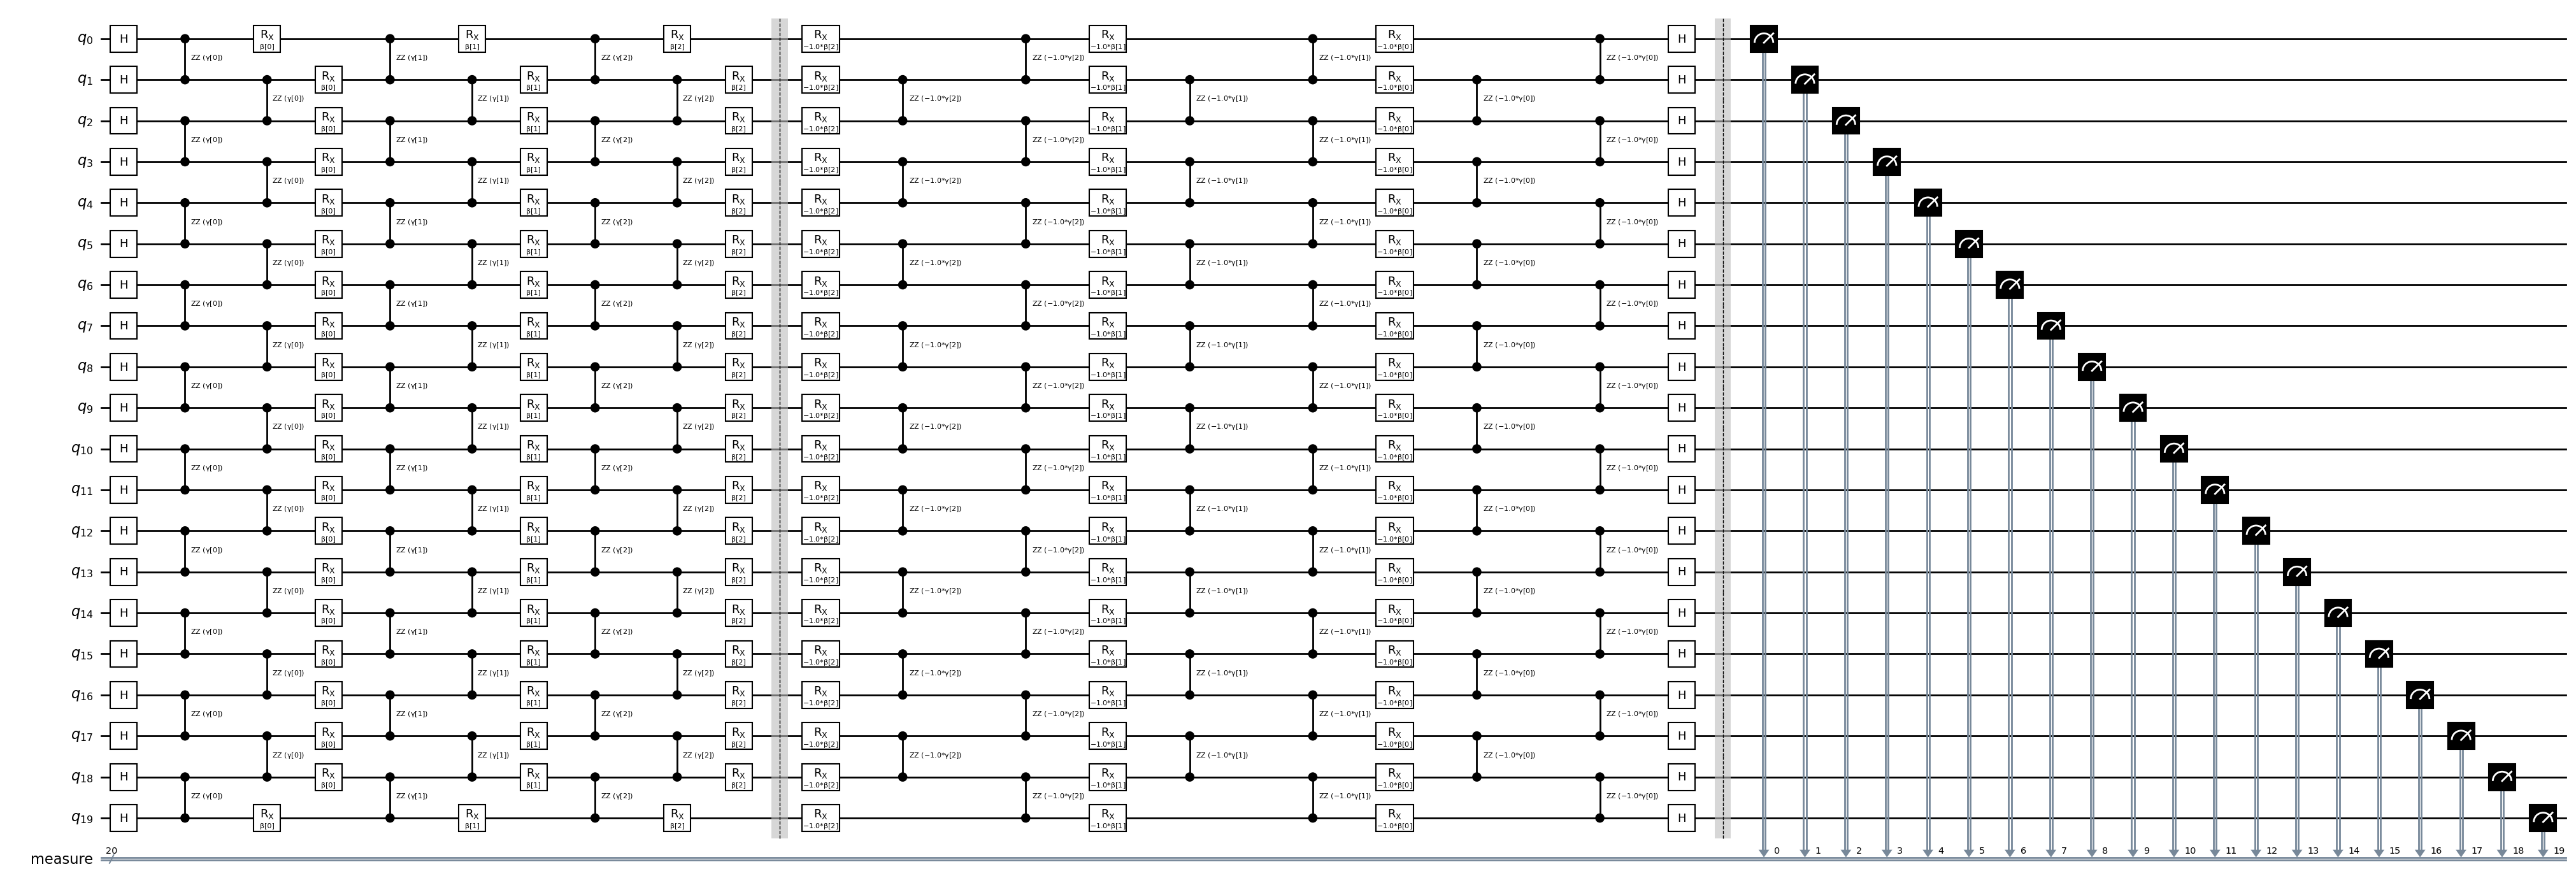

In [3]:
num_qubits = 20
p = 3
qaoa = build_compute_uncompute_qaoa_circuit(num_qubits,2*p)
qaoa.draw('mpl', style='bw', fold=-1)

We assign some random parameters for the qaoa circuit

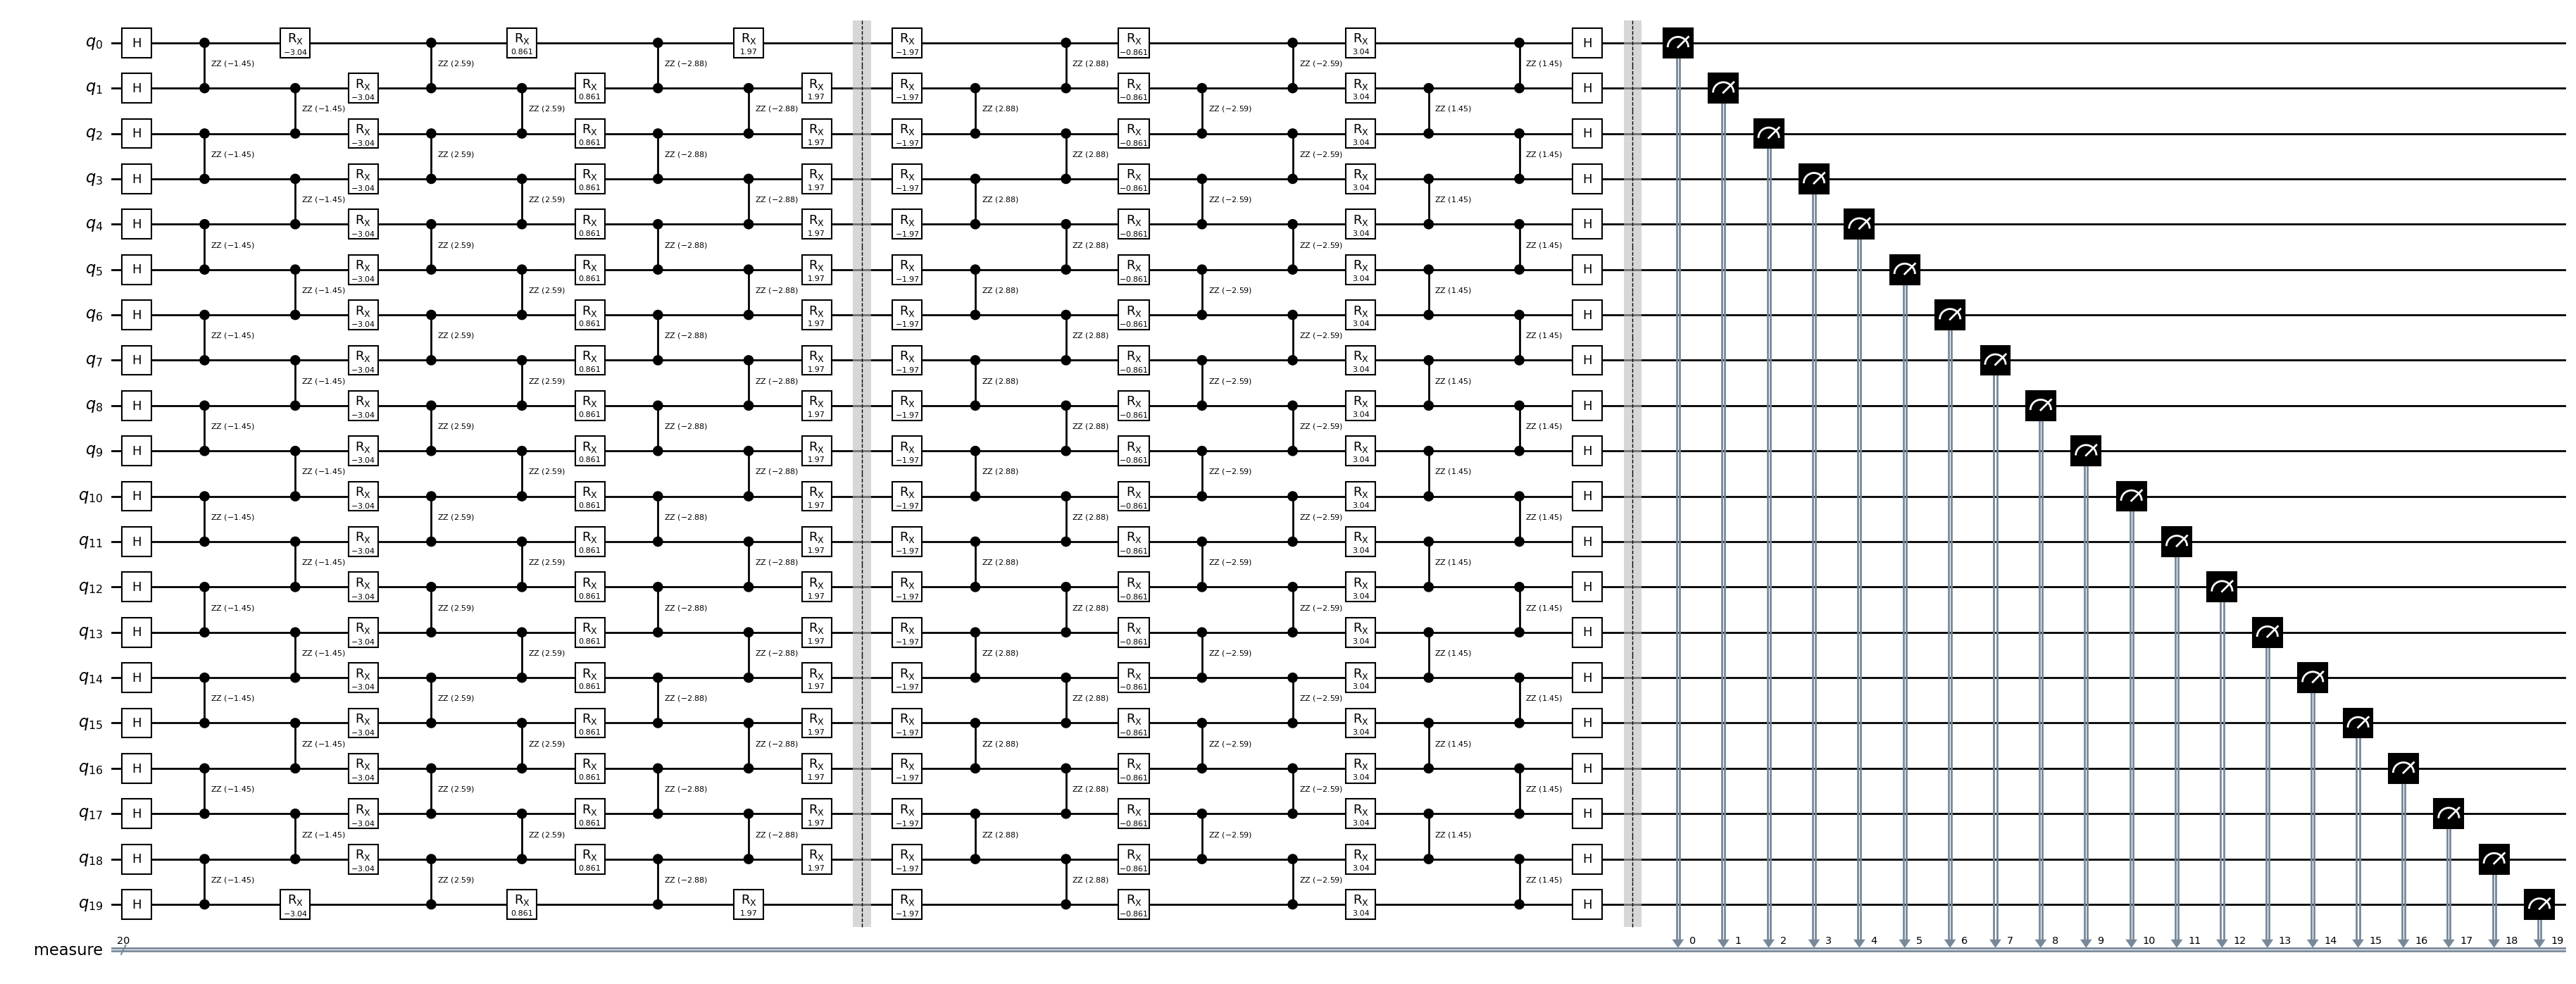

In [4]:
params = produce_qaoa_parameters(p, seed=0)
qaoa = qaoa.assign_parameters(params)
qaoa.draw('mpl', style='bw', fold=-1)

### Optimize

In general, $\lambda \in \mathbb{Z}$, and the most default values of $\lambda$ used for ZNE are $\{1,3,5\}$. However, we note that the above circuit has a 2-qubit depth of 12. Therefore, folding it with $\lambda = 5$ will create a circuit with 2-qubit depth of 60. The signal obtained from such a deep circuit may not be reliable enough for faithful extrapolation. Therefore, we shift to partial folding, where $\lambda \in \mathbb{R}$. In particular, we shall use $\lambda = \{1,1.2,1.4\}$.

$\lambda = 1.2$ implies that 2 out of 10 gates are selected randomly for folding. Below we show an example of this using the <a href='https://github.com/qiskit-community/prototype-zne/tree/main'>prototype-zne</a> package. Note that for the rest of the notebook, we shall use Qiskit Runtime to incorporate ZNE. This is simply for better visualization.

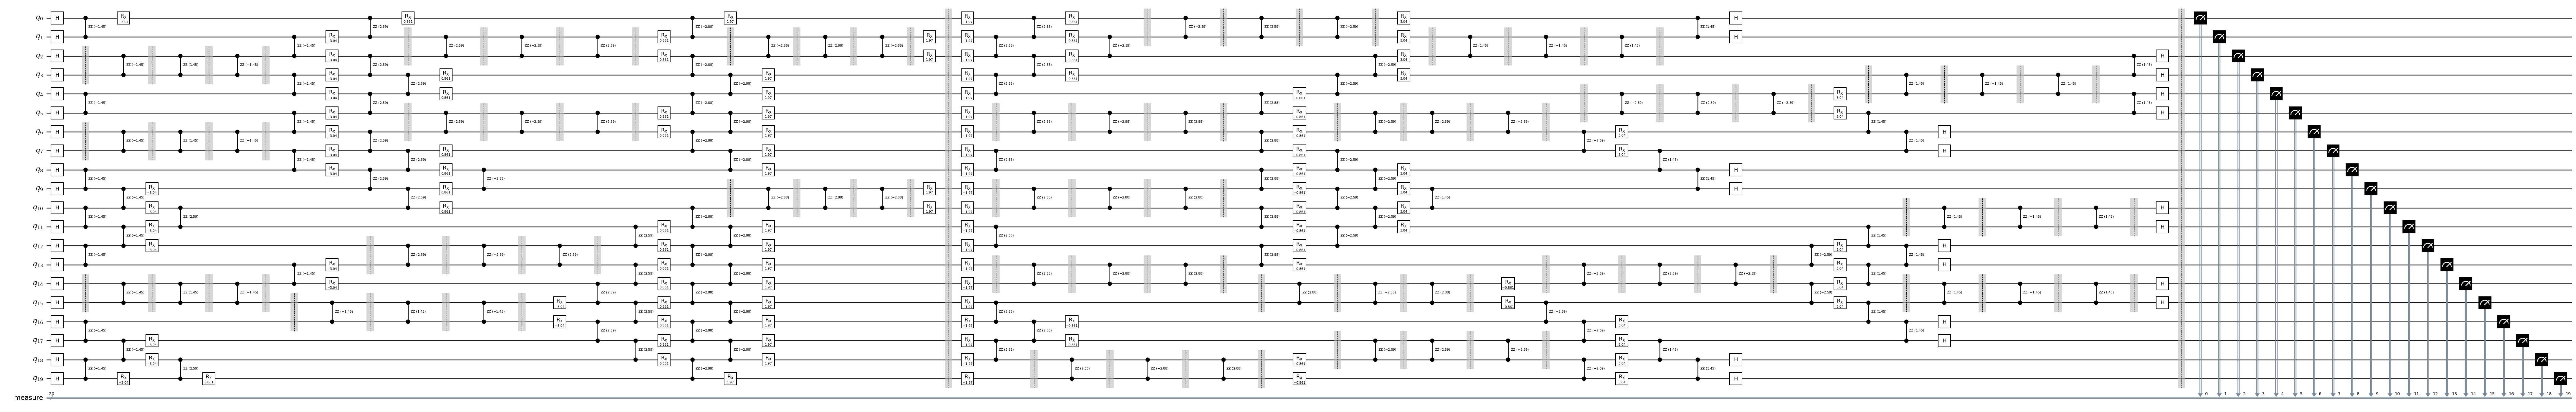

In [5]:
from zne.noise_amplification import TwoQubitAmplifier

noise_amplifier = TwoQubitAmplifier(sub_folding_option='random', random_seed=0)

test_qc = noise_amplifier.amplify_circuit_noise(qaoa, 1.4)
test_qc.draw('mpl', style='bw', fold=-1)

We observe that some of the two qubit gates have been folded. This ensures that 

<ol>
    <li>the depth of the circuit does not increase too much due to folding</li>
    <li>hence, the increase is noise is also low, resulting in better signal</li>
    <li>since the increase in noise is low, low order extrapolator, such as linear, degree-2 polynomial etc. are sufficient for the process</li>
</ol>

### Run the circuit

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator

In [7]:
service = QiskitRuntimeService()
backend = service.get_backend('ibm_auckland')
session = Session(backend=backend)

We shall use noise factors ($\lambda$) as $\{1,1.2,1.4\}$. As discussed above, for such a folding, the increase in noise in low, and a linear extrapolator is often sufficient to approximate the zero noise expectation value.

In [8]:
zne_options = Options()
zne_options.resilience_level = 2 # applies ZNE
zne_options.resilience.noise_factors = [1, 1.2, 1.4]
zne_options.resilience.extrapolator = 'LinearExtrapolator'
zne_estimator = Estimator(session=session, options=zne_options)

Now we can run the circuit using the previous options and estimator. For this notebook we shall use the average over all weight-1 Z type observable.

In [9]:
from qiskit.quantum_info import SparsePauliOp

In [10]:
observable = ['I'*i + 'Z' + 'I'*(qaoa.num_qubits-i-1) for i in range(qaoa.num_qubits)]
observable = SparsePauliOp(observable, coeffs=[1/qaoa.num_qubits]*len(observable))
observable

SparsePauliOp(['ZIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIZ'],
              coeffs=[0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j])

In [11]:
job = zne_estimator.run(qaoa, observable)

### Postprocess

In the postprocessing step we shall get the expectation value of the circuit and observable obtained using ZNE with partial folding.

In [12]:
result = job.result()

In [13]:
print(f'Expectation value with ZNE with partial folding is {result.values[0]}')

Expectation value with ZNE with partial folding is 0.6055000000000008


### Inference

The ideal expectation value of the circuit is $+1$. The value we obtained using partial folded ZNE is $\sim 0.6$. Although it may seem that the result is not sufficiently close to the ideal value, we can verify that the extrapolated result is indeed better than running without ZNE.

The following provides the expectation values corresponding to $\lambda = \{1, 1.2, 1.4\}$.

In [28]:
result.metadata[0]['zne']['noise_amplification']['values']

[0.35455000000000003, 0.3246, 0.25670000000000004]

This asserts that

<ol>
    <li>The obtained extrapolated expectation value is significantly better than the noisy expectation value.</li>
    <li>Even at $\lambda = 1.4$, the expectation value is $\sim 0.25$. Therefore, it can be realized that without partial folding, i.e., using noise factors such as $\lambda = \{1,3,5\}$ would result in folded expectation values very close to 0. In other words, hardly any signal would be retained at that scale, and therefore the extrapolation will be unreliable.</li>
</ol>

It may be possible to further improve the result obtained from this method. One potential method is to use measurement error mitigation, and twirling (which avoids coherent error, making the channel effectively Pauli), as shown in

*Majumdar, R., Rivero, P., Metz, F., Hasan, A., & Wang, D. S. (2023, September). Best practices for quantum error mitigation with digital zero-noise extrapolation. In 2023 IEEE International Conference on Quantum Computing and Engineering (QCE) (Vol. 1, pp. 881-887). IEEE.*

Another method can be to learn the noise in the circuit, and perform the folding accordingly, as shown in

*Kim, Y., Eddins, A., Anand, S., Wei, K. X., Van Den Berg, E., Rosenblatt, S., ... & Kandala, A. (2023). Evidence for the utility of quantum computing before fault tolerance. Nature, 618(7965), 500-505.*

In [3]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright